GenerateFramesFiles.py

Maria Okounkova 

Notebook for generating frames files for LIGO data analysis, whether from NR simulation .h5 files, or using the a gravitational waveform surrogate model

### Imports and setup

In [61]:
import matplotlib.pyplot as plt
import matplotlib
import gwsurrogate
import numpy as np
import scri
import h5py
from astropy import constants as const
from scipy.interpolate import CubicSpline
from scipy.interpolate import InterpolatedUnivariateSpline
from pycbc.detector import Detector
from gwpy.timeseries import TimeSeries
from gwpy.detector import Channel
import os
from shutil import copyfile
import fileinput
import seaborn as sns
import math
from math import pi
import pycbc
from pycbc.filter.matchedfilter import overlap

## if you need the surrogate data: 
##gwsurrogate.catalog.pull('NRSur7dq4')

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 30
matplotlib.rcParams['ytick.labelsize'] = 30
matplotlib.rcParams['xtick.major.size'] = 20
matplotlib.rcParams['ytick.major.size'] = 20
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['xtick.minor.size'] = 10
matplotlib.rcParams['ytick.minor.size'] = 10
matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams['legend.frameon'] = True
matplotlib.rcParams['lines.linewidth'] = 3

### Helper functions

In [62]:
## Helper functions
def Ramp(time, t_s, t_r):
    """ Ramp function for tapering the waveform"""
    if (time < t_s):
        return 0.0
    elif time > (t_s + t_r):
        return 1.0
    else:
        t = (time - t_s)/t_r
        return t**5*(126 + t*(-420 + t*(540 + t*(-315 + 70*t))))
    
def swsh(s, modes, theta, phi, psi=0):
    """
    Return a value of a spin-weighted spherical harmonic of spin-weight s. 
    If passed a list of several modes, then a numpy array is returned with 
    SWSH values of each mode for the given point.
    For one mode:       swsh(s,[(l,m)],theta,phi,psi=0)
    For several modes:  swsh(s,[(l1,m1),(l2,m2),(l3,m3),...],theta,phi,psi=0)
    """
    import spherical_functions as sf
    import quaternion as qt
    return sf.SWSH(qt.from_spherical_coords(theta, phi), s, modes) * np.exp(1j * s * psi)

def GetPeakTime(time, data): 
    """ Grab the peak time of some data """
    t_peak = time[np.argmax(data)]
    return t_peak

def SubtractPeakTime(time, data): 
    """ Subtract the peak time of some data """
    t_peak = GetPeakTime(time, data)
    return time - t_peak

def dt_eval(time):
    """ Return the time step of a given time array """
    return (time[1] - time[0])

def df_eval(time):
    """ Return the delta_f of a given time array """
    delta_t = dt_eval(time)
    return 1.0/(time[-1] - time[0] + delta_t)

def PrintMassParameters(m_total, q):
    """ Given a total mass m_total and mass ration q >= 1, 
        print out the chirp mass and individual masses """
    m2 = m_total / (1 + q)
    m1 = q*m2
    m_chirp = (q/(1+q)**2)**(3/5)*m_total
    print('Chirp mass: ', m_chirp, ', mass 1: ', m1, 'mass 2: ', m2)

In [18]:
PrintMassParameters(68, 1.0/0.8)

Chirp mass:  29.378924880880138 , mass 1:  37.77777777777778 mass 2:  30.22222222222222


### Extrapolate the waveforms that we're interested in

In [43]:
# ## Extrapolate the waveforms
# scri.extrapolate(
#     InputDirectory = 'Waveforms/Lev1',
#     OutputDirectory = 'Waveforms/Lev1',
#     DataFile = 'rh_FiniteRadii_CodeUnits.h5',
#     ChMass = 1.000044463203, 
#     UseStupidNRARFormat = True, 
# )
# scri.extrapolate(
#     InputDirectory = 'Waveforms/Lev2',
#     OutputDirectory = 'Waveforms/Lev2',
#     DataFile = 'rh_FiniteRadii_CodeUnits.h5',
#     ChMass = 1.0000147234369998, 
#     UseStupidNRARFormat = True, 
# )
# scri.extrapolate(
#     InputDirectory = 'Waveforms/Lev3',
#     OutputDirectory = 'Waveforms/Lev3',
#     DataFile = 'rh_FiniteRadii_CodeUnits.h5',
#     ChMass = 1.000000289914, 
#     UseStupidNRARFormat = True, 
# )

### Read in the extrapolated waveforms

In [78]:
## Read in the extrapolated modes
def ReadExtrapolatedModes(file, params_dict, interpolate = True):
    """ 
        File is the file containing the extrapolated waveform that we want to read in.
        For params_dict, 
        mass_msun is the total mass of the system in solar masses, and 
        dist_mpc is the distance to the system in kpc. 
        theta and phi are angles determining the inclination.
        dt is the timestep (reciprocal of the sampling rate)
        
        If we want to interpolate the waveform to have even timesteps dt, then 
        set interpolate to True. Otherwise, we'll return the data without 
        performing the interpolation """

    ## Convert distance to kpc and mass into solar masses
    mass = params_dict['mass']
    dist_mpc = params_dict['dist_mpc']
    theta = params_dict['theta']
    phi = params_dict['phi'] 
    dt = params_dict['dt']
    dist_kpc = dist_mpc * 1000 * const.kpc
    mass_msun = mass * const.M_sun
    
    ## Read in the data
    f = h5py.File(file, 'r')
    
    ## grab the length of the waveform first
    data = f['Extrapolated_N2.dir']['Y_l2_m2.dat']
    time = np.array(data[:,0])
    
    h_plus = np.zeros(len(time))
    h_cross = np.zeros(len(time))

    #modes = [(2, -2), (2,2)]
    modes = [(l,m) for l in range(2,5) for m in range(-l, l+1)]
    for mode in modes: 
        
        ## Grab the mode in question
        l = mode[0]
        m = mode[1]
        
        data = f['Extrapolated_N2.dir']['Y_l' + str(l) + '_m' + str(m) + '.dat']
        real = np.array(data[:,1])
        imag = np.array(data[:,2])
        coeff = real + 1j * imag
        
        ## Multiply by the corresponding spin-weighted spherical harmonic
        Ylm = swsh(-2, [(l,m)], theta=theta, phi=phi, psi=0) 
        h = coeff * Ylm 
        
        ## Add to our h_plus and h_cross computations
        h_plus = h_plus + np.real(h)
        h_cross = h_cross - np.imag(h) 
        
        
    ## Apply the astrophysical parameters
    time = time*mass_msun*const.G/(const.c**3)
    h_plus = h_plus*const.G*mass_msun/((const.c)**2*dist_kpc)
    h_cross = h_cross*const.G*mass_msun/((const.c)**2*dist_kpc)

    ## Taper the waveform and apply the ramp (need to start the waveform at zero for this)
    time = time - time[0]
    ramp = np.array([Ramp(t.value, 0.1, 0.3) for t in time])
    
    h_plus = h_plus * ramp
    h_cross = h_cross * ramp
    
    ## Now subtract off the peak time (this makes the spine interpolation easier)
    amp = np.sqrt(h_plus**2 + h_cross**2)
    time = time - time[np.argmax(amp)]
    
    if not interpolate:
        print("Not performing the interpolation")
        return time, h_plus, h_cross
    
    ## Now build the interpolants 
    cs_plus = InterpolatedUnivariateSpline(time, h_plus)
    cs_cross = InterpolatedUnivariateSpline(time, h_cross)

    ## Now create an evenly-spaced time array and interpolate the data 
    time_cs = np.arange(time[0].value, time[-1].value, dt)

    h_plus_cs = cs_plus(time_cs) 
    h_cross_cs = cs_cross(time_cs) 
    
    ## Return these new interpolated values
    return time_cs, h_plus_cs, h_cross_cs, np.sqrt(h_plus_cs**2 + h_cross_cs**2)
    

### Evaluate the surrogate

In [64]:
## Load in the surrogate
sur = gwsurrogate.LoadSurrogate('NRSur7dq4')

/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_surrogate.py:245: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.t = h5file['t_ds'].value
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_surrogate.py:272: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  'coefs': group['%s_coefs'%(key)].value,
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_surrogate.py:273: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  'bfOrders': group['%s_bfOrders'%(key)].value
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_surrogate.py:282: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  'coefs': group['%s_%d_coefs'%(key, i)].value,
/home/maria.okounkova/.local/lib/python3.6/site-packages/gwsurrogate/new/precessing_sur

Loaded NRSur7dq4 model


In [116]:
## Surrogate evaluation
def EvaluateSurrogate(params_dict, surrogate_projection=True):
    """ Evaluate the surrogate waveform 
        If surrogate_projection is true, then use the native surrogate inclination calculation routine
        Otherwise combine ourselves using SWSH"""
    
    if (surrogate_projection):
        ## Use the native surrogate inclination computation
   
        """ Surrogate documentation: If inclination/phi_ref are specified, the complex strain (h =
                 hplus -i hcross) evaluated at (inclination, pi/2 - phi_ref) on
                 the sky of the reference frame is returned.
         
            In order to agree with NR convetions, need phi_ref = pi/2 - phi"""
    
        print("spins: ", params_dict['chiA'], params_dict['chiB'])
        data = sur(params_dict['q'], params_dict['chiA'], params_dict['chiB'], \
                   dt = params_dict['dt'], units = 'mks', M = params_dict['mass'], \
                   dist_mpc = params_dict['dist_mpc'], f_low = params_dict['f_low'], \
                   inclination = params_dict['theta'], ellMax = 4, phi_ref = pi/2 - params_dict['phi']) 

        time = data[0]
        h_plus = np.real(data[1])
        h_cross = -1 * np.imag(data[1])
        
        time = time - time[0]
        #ramp = np.array([Ramp(t, 0.27, 0.3) for t in time])
        ramp = np.array([Ramp(t, 0.22, 0.25) for t in time])
    
        h_plus = h_plus * ramp
        h_cross = h_cross * ramp
    
        ## Now subtract off the peak time (this makes the spine interpolation easier)
        amp = np.sqrt(h_plus**2 + h_cross**2)
        time = time - time[np.argmax(amp)]
    
        return time, h_plus, h_cross, np.sqrt(h_plus**2 + h_cross**2)
        

### Pad the data in time and project to detectors

In [66]:
## Time padding and projection to detectors
def ProjectToDetectors(ra, dec, pol, t0, plus, cross, time):
    '''
    ra - Right Ascension
    dec - Declination
    pol - Polarization Angle
    t0 - reference time for when signal reaches Hanford
    '''
    
    ## Grab the dt
    dt = dt_eval(time)
    
    d_H1 = Detector("H1")
    d_L1 = Detector("L1")
    
    # The time delay of the signal between the detectors
    t_delay = d_L1.time_delay_from_detector(d_H1, ra, dec, t0)
    
    # Round the delay time to the nearest dt (this assumes that t_gps is a multiple of dt)
    t_delay_rounded = round(t_delay / dt) * dt
    print("True delay time: ", t_delay, " Nearest multuple of dt: ", t_delay_rounded, " dt: ", dt)
    
    #Antenna Patterns
    Fp_H1, Fc_H1 = d_H1.antenna_pattern(ra, dec, pol, t0)
    Fp_L1, Fc_L1 = d_L1.antenna_pattern(ra, dec, pol, t0 + t_delay_rounded)
    
    #project
    h_H1 = Fp_H1*plus + Fc_H1*cross
    h_L1 = Fp_L1*plus + Fc_L1*cross
    
    #Shift times
    time_H1 = time
    time_L1 = time + t_delay_rounded
    
    return h_H1, h_L1, time_H1, time_L1

def PadZeroes(time, strain, t_gps, peak_time_in_segment, segment_length):

    ## Now to pad the data with zeros -- we want to pad both the H1 and L1 data so that 
    ## they span the same gps times
    dt = dt_eval(time)
    segment_start_time = t_gps - peak_time_in_segment
    segment_end_time = segment_start_time + segment_length
    
    print("Segment start: ", segment_start_time, " Segment end: ", segment_end_time)
    
    ## Do Hanford first (see how much we need to pad in order to get )
    start_pad_time = time[0] - segment_start_time
    end_pad_time = segment_end_time - time[-1]
    
    ## Figure out how many integer zeroes to pad the data
    start_pad_zeros = start_pad_time / dt
    end_pad_zeros = end_pad_time / dt
    
    print("Start pad: ", start_pad_zeros, " End pad: ", end_pad_zeros)
    
    ## Pad the data with zeroes 
    strain_padded = np.pad(strain, (int(start_pad_zeros), int(end_pad_zeros)), 'constant', constant_values=(0.0, 0.0))
    time_padded = np.arange(0., segment_length + dt, dt) + segment_start_time

    
    return time_padded, strain_padded

    
def PadAndProject(time, h_plus, h_cross, params_dict):
    """ Given a time, h_plus, and h_cross array, pad the data to the desired segment length, and project 
        to detectors.
        Within params_dict, 
        t_gps is the gps time of the event
        peak_time_in_segment is the time within the segment corresponding to the peak of the waveform (in sec)
        segmentt_length is the length of the segment (in sec)
        ra is the right ascention
        dec is the declination
        pol is the polarization
        """
       
    ## Grab the dt
    dt = dt_eval(time)
    print("dt: ", dt, " Frequency: ", 1/dt)
    
    ## The present peak time in the gravitational waveform (in secs)
    ## This is not the gps time, but rather should be ~0 from the surrogate / NR waveform 
    t_peak = time[np.argmax(h_plus**2 + h_cross**2)]
    print("First peak time: ", t_peak)
    
    ## Shift the times by the gps time, so that the peak of the waveform (in Handford)
    ## is now at t_gps
    time = time + params_dict['t_gps']

    ## Double check the peak time
    t_peak = time[np.argmax(h_plus**2 + h_cross**2)]
    print("Shifted peak time: ", t_peak)
    
    ## Project data to the detectors -- both timeH and timeL % dt will be zero
    strainH, strainL, timeH, timeL = ProjectToDetectors(ra=params_dict['ra'], dec=params_dict['dec'], \
                                                        pol=params_dict['pol'], t0=params_dict['t_gps'], \
                                                        plus=h_plus, cross=h_cross, time=time)
    
        
    ## Pad the data with zeros
    timeH, strainH = PadZeroes(timeH, strainH, params_dict['t_gps'], params_dict['peak_time_in_segment'], \
                                               params_dict['segment_length'])
    timeL, strainL = PadZeroes(timeL, strainL, params_dict['t_gps'], params_dict['peak_time_in_segment'], \
                                               params_dict['segment_length'])
    
    print(timeH[0], timeH[-1])
    print(timeL[0], timeL[-1])
        
    ## Return the projected data
    return timeH, strainH, timeL, strainL

### Write frames files

In [67]:
## Generate frames files from the Hanford and Livingston data

def GenerateFrames(rh_dir, timeH, strainH, timeL, strainL, params_dict):
    """ Generate frames files given hanford and livingston data.
        rh_dir is the directory base directory for the data 
        Also make bayeswave files if necessary """
    
    ## Write the time series    
    #out_dir = rh_dir + '/' + rh_dir.split('/')[-1] + '_mtotal_' + str(params_dict['mass']) \
    #                                                             + '_dist_' + str(params_dict['dist_mpc'])
    
    #os.mkdir(rh_dir)
    #os.mkdir(out_dir)
    
    dt = dt_eval(timeH)
    segment_start = timeH[0]
    segment_length = timeH[-1] - timeH[0]
    
    H1 = TimeSeries(strainH,sample_rate=1/dt,epoch=timeH[0],channel="H1:LDAS_STRAIN")
    L1 = TimeSeries(strainL,sample_rate=1/dt,epoch=timeL[0],channel="L1:LDAS_STRAIN")
    
    #H1_name = "H-H1_HOFT-" + str(segment_start) + \
    #                "-" + str(int(segment_length)) + ".gwf"
    #L1_name = "L-L1_HOFT-" + str(segment_start) + \
    #                "-" + str(int(segment_length)) + ".gwf"
    #H1.write(out_dir + "/" + H1_name)
    #L1.write(out_dir + "/" + L1_name)
    
    H1.write(rh_dir + "/H1.gwf")
    L1.write(rh_dir + "/L1.gwf")
    
    ## Copy over the noise files
    #copyfile('PSDs/design/aLIGOZeroDetHighPower-PSD.txt', out_dir + '/aLIGOZeroDetHighPower-PSD.txt')
    #copyfile('PSDs/design/aLIGOZeroDetHighPower-PSD_25Hz.txt', out_dir + '/aLIGOZeroDetHighPower-PSD_25Hz.txt')
    
    ## Make the bayeswave cache files
    #with open(out_dir + '/H1_Cache.lcf', 'a') as file:
    #    file.write("-\t-\t-\t-\tfile://localhost" + '/home/maria.okounkova/BeyondGRAnalysis/' + out_dir + '/' + H1_name + '\n')
    #with open(out_dir + '/L1_Cache.lcf', 'a') as file:
    #    file.write("-\t-\t-\t-\tfile://localhost" + '/home/maria.okounkova/BeyondGRAnalysis/' + out_dir + '/' + L1_name + '\n')
        
    ## Copy over the bayewave ini files
    #copyfile('run_bw.sh', out_dir + '/run_bw.sh')
    #copyfile('dCS.ini', out_dir + '/dCS.ini')
    #print(out_dir)
    
    ## Change the path to the cache files in the copied dCS.ini file
    #with fileinput.FileInput(out_dir + '/dCS.ini', inplace=True, backup='.bak') as file:
    #    for line in file:
    #        print(line.replace('CACHE_DIR', out_dir), end='')
        

### Compute SNR

In [68]:
def ComputeSNR(time, strain):
    """ Given a time-domain strain and the corresponding time array, 
        compute the SNR using pycbc """

    ## Compute dt and df
    delta_t = dt_eval(time)
    delta_f = df_eval(time)
    
    ## Read in PSD and construct interpolant
    psd_file = "PSDs/design/aLIGOZeroDetHighPower-PSD.txt"
    psd_frequencies, psd_vals = np.loadtxt(psd_file, comments="#",usecols=([0,1]),unpack=True)
    cs = InterpolatedUnivariateSpline(psd_frequencies, psd_vals)

    ## Interpolated PSD onto df-spaced values
    freqs = delta_f * np.array(range(len(strain)))
    psd = cs(freqs)

    ## Timeseries and Frequency series objects for pycbc computation
    strain_ts = pycbc.types.timeseries.TimeSeries(strain, delta_t = delta_t, epoch = time[0])
    psd_fs = pycbc.types.frequencyseries.FrequencySeries(psd, delta_f = delta_f, epoch = timeH_sur[0])

    overlap_val = overlap(vec1 = strain_ts, vec2 = strain_ts, psd = psd_fs, normalized = False) 
    
    ## Take the square root of the overlap for the SNR
    return(np.sqrt(overlap_val))

### Compute waveforms

In [137]:
def EvaluateNRWaveform(p_in, p_out, params_dict):
    
    time, h_plus, h_cross, amp = ReadExtrapolatedModes(p_in, params_dict, interpolate = True)
    timeH, strainH, timeL, strainL = PadAndProject(time, h_plus, h_cross, params_dict)
    #print("H SNR: ", ComputeSNR(timeH, strainH))
    #print("L SNR: ", ComputeSNR(timeL, strainL))
    GenerateFrames(p_out, timeH, strainH, timeL, strainL, params_dict)
    
    
def EvaluateSurrogateWaveform(p_out, params_dict):
    
    time_sur, h_plus_sur, h_cross_sur, amp_sur = EvaluateSurrogate(params_dict, surrogate_projection=True)
    timeH_sur, strainH_sur, timeL_sur, strainL_sur = PadAndProject(time_sur, h_plus_sur, h_cross_sur, params_dict)
    #print("H SNR: ", ComputeSNR(timeH_sur, strainH_sur))
    #print("L SNR: ", ComputeSNR(timeL_sur, strainL_sur))
    GenerateFrames(p_out, timeH_sur, strainH_sur, timeL_sur, strainL_sur, params_dict)
    

My_Params_Dict = {'dt' : 1/2048, 't_gps' : 1126259462.0, 'peak_time_in_segment' : 8.0, 'segment_length' : 16.0, \
               'dist_mpc' : 200.0, 'mass' : 68.0, 'q' : 1.2212532137858916, \
               'chiA' : [0, 0, 0.329892752405], 'chiB' : [0, 0, -0.439940981499], \
               'f_low' : 0, 'theta' : pi, 'phi' : 0, \
               'ra' : 1.952318922, 'dec' : -1.26967171703, 'pol' : 0.824043851821}
    
EvaluateSurrogateWaveform('BilbyPE/Temp/Frames', My_Params_Dict)
EvaluateNRWaveform('/home/maria.okounkova/BeyondGRAnalysis/Waveforms/Lev2/BackgroundStrain.h5', 'BilbyPE/NR_FramesCloser/Frames_NR', My_Params_Dict)

spins:  [0, 0, 0.329892752405] [0, 0, -0.439940981499]
dt:  0.00048828125  Frequency:  2048.0
First peak time:  0.0
Shifted peak time:  1126259462.0
True delay time:  -0.006985699700979881  Nearest multuple of dt:  -0.0068359375  dt:  0.00048828125
Segment start:  1126259454.0  Segment end:  1126259470.0
Start pad:  13434.0  End pad:  16316.0
Segment start:  1126259454.0  Segment end:  1126259470.0
Start pad:  13420.0  End pad:  16330.0
1126259454.0 1126259470.0
1126259454.0 1126259470.0
dt:  0.00048828125  Frequency:  2048.0
First peak time:  -8.368492126464844e-05
Shifted peak time:  1126259461.9999163
True delay time:  -0.006985699700979881  Nearest multuple of dt:  -0.0068359375  dt:  0.00048828125
Segment start:  1126259454.0  Segment end:  1126259470.0
Start pad:  14513.82861328125  End pad:  16289.17138671875
Segment start:  1126259454.0  Segment end:  1126259470.0
Start pad:  14499.82861328125  End pad:  16303.17138671875
1126259454.0 1126259470.0
1126259454.0 1126259470.0


In [135]:
My_Params_Dict = {'dt' : 1/2048, 't_gps' : 1126259462.0, 'peak_time_in_segment' : 8.0, 'segment_length' : 16.0, \
               'dist_mpc' : 400.0, 'mass' : 68.0, 'q' : 1.2212532137858916, \
               'chiA' : [0, 0, 0.329892752405], 'chiB' : [0, 0, -0.439940981499], \
               'f_low' : 0, 'theta' : pi, 'phi' : 0, \
               'ra' : 1.952318922, 'dec' : -1.26967171703, 'pol' : 0.824043851821}

p_in = '/home/maria.okounkova/BeyondGRAnalysis/Waveforms/Lev3/dCS_Strain_0p0.h5'
time, h_plus, h_cross, amp = ReadExtrapolatedModes(p_in, My_Params_Dict, interpolate = True)
time_sur, h_plus_sur, h_cross_sur, amp_sur = EvaluateSurrogate(My_Params_Dict, surrogate_projection=True)
    

spins:  [0, 0, 0.329892752405] [0, 0, -0.439940981499]


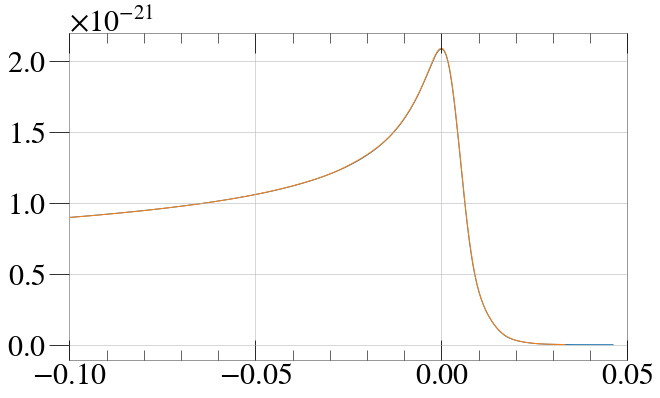

In [136]:
plt.figure(figsize = (10, 6))

plt.plot(time, amp, lw = 1.0) #np.sqrt(h_plus**2 + h_cross**2), lw = 1.0)

plt.plot(time_sur, amp_sur, lw = 1.0) #np.sqrt(h_plus_sur**2 + h_cross_sur**2), lw = 1.0)

plt.xlim(-0.1, 0.05)


plt.show()

### Plot the frame files

#### Injected frames files

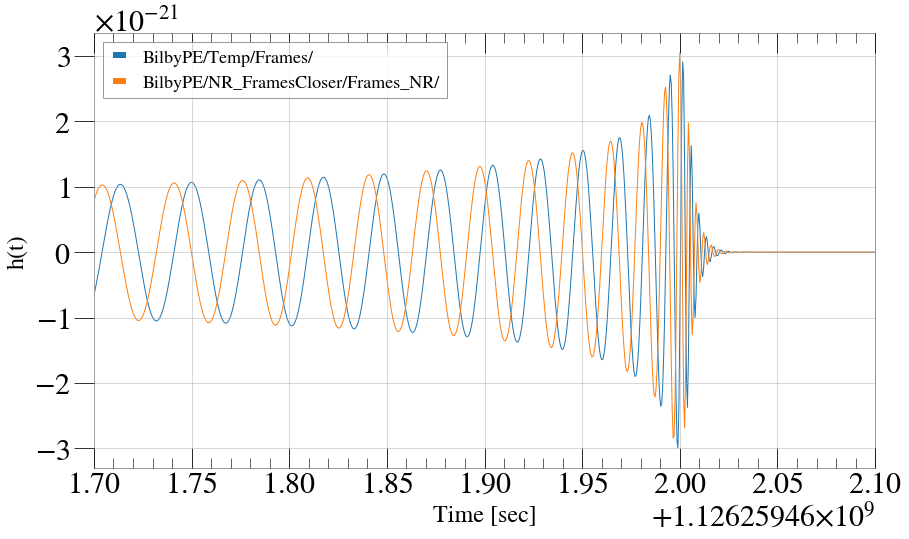

In [139]:
plt.figure(figsize=(14, 8))

for p, offset in zip(['BilbyPE/Temp/Frames/', 'BilbyPE/NR_FramesCloser/Frames_NR/'], [0.0, 0.0]):

    det = "H1"
    sH = TimeSeries.read(source = p + det + '.gwf', channel=det+":LDAS_STRAIN")
    #det = "L1"
    #sL = TimeSeries.read(source = p + det + '.gwf', channel=det+":LDAS_STRAIN")
    tH = sH.times
    plt.plot(np.array(tH) + offset, sH, '-', lw = 1.0, label = p)

plt.xlabel('Time [sec]')
plt.legend()
plt.ylabel('h(t)')
tt = 1126259462.0
plt.xlim(tt - 0.3, tt + 0.1)
        
#plt.tight_layout()
plt.show()

#### Plot frames files for dCS params

0.005239009857177734 s
14512
1126259462.0463867
0.005239009857177734 s
14512
1126259462.0463867
0.005239009857177734 s
14512
1126259462.0463867
0.005239009857177734 s
14510
1126259462.0463867


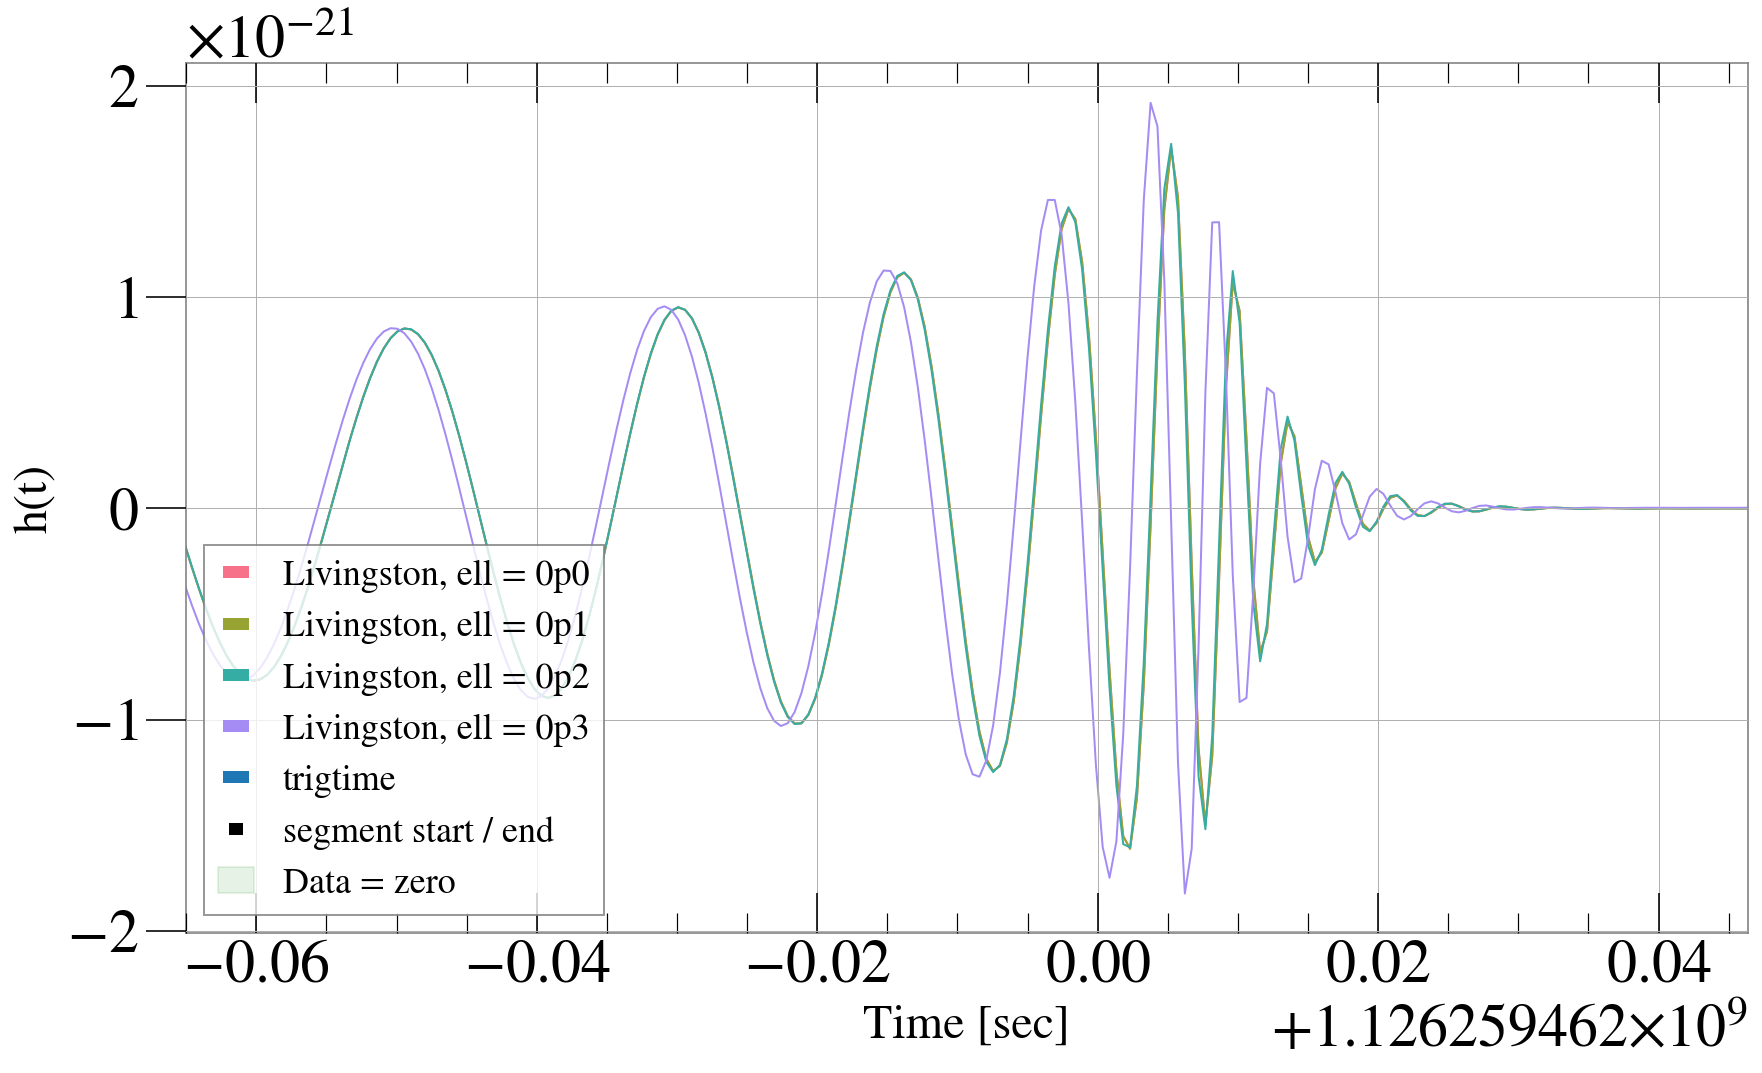

In [35]:
fig, ax = plt.subplots(figsize=(14, 8))

ells = ["0p0", "0p1", "0p2", "0p3"]
cs = sns.color_palette('husl', n_colors=len(ells))
for ell, color in zip(ells, cs):
    my_dir = "dCS_" + ell


    ## Livingston comes after hanford in this case
    sH = TimeSeries.read(source = '/home/maria.okounkova/BeyondGRAnalysis/Frames/'+my_dir+'/'+my_dir+'_mtotal_68_dist_400/H-H1_HOFT-1126259454-16.gwf', channel="H1:LDAS_STRAIN")
    tH = sH.times

    sL = TimeSeries.read(source = '/home/maria.okounkova/BeyondGRAnalysis/Frames/'+my_dir+'/'+my_dir+'_mtotal_68_dist_400/L-L1_HOFT-1126259454-16.gwf', channel="L1:LDAS_STRAIN")
    tL = sL.times
    
    ## Livingston comes after Hanford
    print(tL[-1] - tH[-1])
    
    ## Find where the data stops / starts being zero
    aa = np.array(np.where(sH == 0)[0])
    bb = aa[1:] - aa[:-1]
    start_index = np.where(bb != 1)[0][0]
    start = tH[start_index].value
    print(start_index)
    
    stop_index = 16479
    stop = tH[stop_index].value
    print(stop)
    #plt.plot(np.array(tH), sH, label='Hanford, ell = ' + ell, lw=1.0, color=color)
    plt.plot(np.array(tL), sL, '-', label='Livingston, ell = ' + ell, lw=1.0, color=color)

## Plot the trigtime for bayeswave
plt.axvspan(tH[0].value, start, label='Data = zero', color='green', alpha=0.1)
plt.axvspan(stop, tH[-1].value, color='green', alpha=0.1)
plt.axvline(1126259462.4107006, label='trigtime')
plt.axvline(1126259456.4107006, ls = '--', label='segment start / end', color='black')
plt.axvline(1126259456.4107006 + 8.0, ls = '--', color='black')
plt.xlabel('Time [sec]')
plt.xlim(start + 0.85, stop)
plt.legend(loc='lower left')
plt.ylabel('h(t)')
#tt = 1126259462.4107006
#plt.xlim(tt - 1.4, tt -0.2)
#plt.xlim(tt - 0.5, tt -0.37)      I 
# plt.tight_layout()
plt.show()

#### Resolution analysis

the distance is 400.0


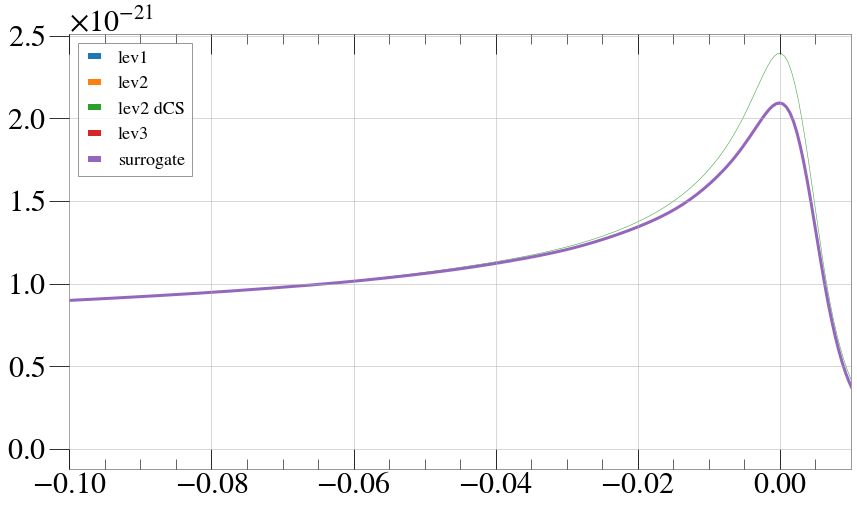

In [342]:
plt.figure(figsize=(14, 8))

def plot_resolution(p, label):
    time, h_plus, h_cross, amp = ReadExtrapolatedModes(p, mass_msun, dist_kpc, theta, phi, \
                                                     dt, interpolate = True)
    
    plt.plot(time, amp, label = label, lw = 0.5)
    
plot_resolution('Waveforms/Lev1/dCS_Strain_0p0.h5', 'lev1')
plot_resolution('Waveforms/Lev2/dCS_Strain_0p0.h5', 'lev2')
plot_resolution('Waveforms/Lev2/dCS_Strain_0p3.h5', 'lev2 dCS')
plot_resolution('Waveforms/Lev3/dCS_Strain_0p0.h5', 'lev3')


time_sur, h_plus_sur, h_cross_sur, amp_sur = EvaluateSurrogate(q, chiA, chiB, mass, dist_mpc, f_low, theta, phi, dt, \
                                                   surrogate_projection=True)
plt.plot(time_sur, amp_sur, label='surrogate')
    

plt.xlim(-0.1, 0.01)
plt.legend()
plt.show()